Epoch 00000 | Total Loss: 9.9924e-01 | Equation Loss: 7.9541e-01 | Initial Loss: 1.5525e-01 | Constraint Loss: 4.8580e-01
Epoch 01000 | Total Loss: 2.7820e-03 | Equation Loss: 2.8888e-04 | Initial Loss: 4.0006e-04 | Constraint Loss: 2.0930e-02
Epoch 02000 | Total Loss: 2.9642e-03 | Equation Loss: 2.3394e-04 | Initial Loss: 4.6632e-04 | Constraint Loss: 2.2639e-02
Epoch 03000 | Total Loss: 2.2281e-03 | Equation Loss: 2.2277e-03 | Initial Loss: 4.3903e-07 | Constraint Loss: 0.0000e+00
Epoch 04000 | Total Loss: 2.2827e-03 | Equation Loss: 1.1897e-04 | Initial Loss: 3.1962e-04 | Constraint Loss: 1.8441e-02
Epoch 05000 | Total Loss: 2.6769e-03 | Equation Loss: 8.9918e-05 | Initial Loss: 4.3466e-04 | Constraint Loss: 2.1523e-02
Epoch 06000 | Total Loss: 1.2899e-03 | Equation Loss: 5.4519e-05 | Initial Loss: 1.2182e-04 | Constraint Loss: 1.1136e-02
Epoch 07000 | Total Loss: 1.0660e-04 | Equation Loss: 3.1420e-05 | Initial Loss: 1.6331e-07 | Constraint Loss: 7.5012e-04
Epoch 08000 | Total Loss

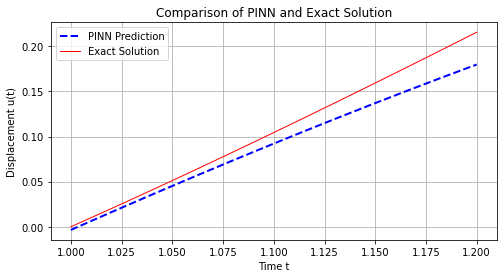

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the Physics-Informed Neural Network (PINN)
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(1, 10)   # Input layer to first hidden layer
        self.fc2 = nn.Linear(10, 10)  # First hidden layer to second hidden layer
        self.fc3 = nn.Linear(10, 1)   # Second hidden layer to output layer
        self.activation = torch.tanh  # Activation function: tanh

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model and optimizer
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Generate training data: domain and initial condition
x_domain = torch.linspace(1, 1.2, 300, requires_grad=True).view(-1, 1)  # Domain points with gradient tracking
x_initial = torch.tensor([[1.0]], requires_grad=True)                    # Initial condition point x=1
y_initial = torch.tensor([[0.0]])                                        # Initial condition y=0

# Training parameters
epochs = 10000  # Number of training epochs

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()

    # --- Compute differential equation residual loss ---
    # Forward pass
    y_pred_domain = model(x_domain)
    # Compute dy/dx (automatic differentiation)
    dy_dx = torch.autograd.grad(
        outputs=y_pred_domain,
        inputs=x_domain,
        grad_outputs=torch.ones_like(y_pred_domain),
        create_graph=True
    )[0]
    # Compute the right-hand side: 2/x * sqrt(y - lnx) + 1/x
    ln_x = torch.log(x_domain)
    term = y_pred_domain - ln_x
    sqrt_term = torch.sqrt(torch.relu(term) + 1e-8)  # Avoid negatives, relu ensures non-negativity
    right_side = 2.0 / x_domain * sqrt_term + 1.0 / x_domain
    # Mean squared error of the equation residual
    equation_loss = torch.mean((dy_dx - right_side) ** 2)

    # --- Constraint loss: enforce y >= lnx ---
    constraint_loss = torch.mean(torch.relu(-term))  # Penalize when term < 0

    # --- Initial condition loss ---
    y_pred_initial = model(x_initial)
    initial_loss = torch.mean((y_pred_initial - y_initial) ** 2)

    # --- Total loss = equation loss + initial condition loss + weighted constraint loss ---
    total_loss = equation_loss + initial_loss + 0.1 * constraint_loss

    # Backpropagation and optimization
    total_loss.backward()
    optimizer.step()

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
        print(
            f'Epoch {epoch:05d} | Total Loss: {total_loss.item():.4e} | '
            f'Equation Loss: {equation_loss.item():.4e} | '
            f'Initial Loss: {initial_loss.item():.4e} | '
            f'Constraint Loss: {constraint_loss.item():.4e}'
        )

# Plot results
x_test = torch.linspace(1, 1.2, 300).view(-1, 1)
y_pred = model(x_test).detach().numpy()

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# Exact solution
y_exact = (np.log(x_test.numpy()))**2 + np.log(x_test.numpy())

plt.figure(figsize=(8, 4))
plt.plot(x_test, y_pred, 'b--', linewidth=2, label='PINN Prediction')
plt.plot(x_test, y_exact, 'r-', linewidth=1, label='Exact Solution')
plt.xlabel('Time t')
plt.ylabel('Displacement u(t)')
plt.legend()
plt.title('Comparison of PINN and Exact Solution')
plt.grid(True)
plt.show()

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
y_exact = y_exact.reshape(-1, 1)
y_p_pinn = y_pred
y_true = y_exact
R2_pinn = r2_score(y_p_pinn, y_true)
mae_pinn = mean_absolute_error(y_p_pinn, y_true)
rmse_pinn = mean_squared_error(y_p_pinn, y_true, squared=False)
inf_norm_pinn = np.linalg.norm(y_p_pinn - y_true, ord = np.inf)

print(f"R2_pinn: {R2_pinn}, mae_pinn: {mae_pinn}, rmse_pinn: {rmse_pinn}, inf_norm_pinn: {inf_norm_pinn}")

R2_pinn: 0.8902105070456791, mae_pinn: 0.014713571406900883, rmse_pinn: 0.017607983201742172, inf_norm_pinn: 0.03576795756816864


In [3]:
import numpy as np
import pandas as pd

data_to_save = pd.DataFrame({
    'x': x_test.flatten(),
    'y_pred_pinn': y_p_pinn.flatten(),
    'y_exact': y_true.flatten()
})

data_to_save.to_csv('pinn_06.csv', index=False)
print(" pinn_06.csv")

数据已保存至 pinn_06.csv
